In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

# icustays

## Read samples

In [6]:
icustays_df = common.read_csv_no_rowid(date_set_path+"icustays.csv")

In [7]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

## Data preproces

In [8]:
# Drop useless colums
icustays_df.drop(['los'], axis=1, inplace=True)

### Process null values

In [9]:
# Check null value in table
common.nan_count(icustays_df)

Total columns: 10
Total rows: 124
--------------
subject_id        0
hadm_id           0
icustay_id        0
dbsource          0
first_careunit    0
last_careunit     0
first_wardid      0
last_wardid       0
intime            0
outtime           0
dtype: int64


### Set the column types

In [10]:
icustays_df.dtypes

subject_id         int64
hadm_id            int64
icustay_id         int64
dbsource          object
first_careunit    object
last_careunit     object
first_wardid       int64
last_wardid        int64
intime            object
outtime           object
dtype: object

In [11]:
# Transfer some date type
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [12]:
icustays_df.dtypes

subject_id                 int64
hadm_id                    int64
icustay_id                 int64
dbsource                  object
first_careunit            object
last_careunit             object
first_wardid               int64
last_wardid                int64
intime            datetime64[ns]
outtime           datetime64[ns]
dtype: object

### Process time value

In [13]:
admittime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [14]:
icustays_mid_df = pd.merge(left=icustays_df, right=admittime_df, how='left', on=['hadm_id'])

In [15]:
def time_process(df, early_col_name, late_col_name, second_early_col_name=None):
    '''
    If first_early_col_name exist, then use late_col - first_early_col_name, else, use then use late_col - second_early_col_name, else set result as NaN
    The result is the time delta, save it as the late column
    '''
    # print(df['hadm_id'])

    if (pd.isna(df[early_col_name]) == False) & (pd.isna(df[late_col_name]) == False):
        return abs(df[late_col_name] - df[early_col_name]).total_seconds()
    elif (pd.isna(second_early_col_name) == False) & (pd.isna(df[late_col_name]) == False):
        return abs(df[late_col_name] - df[second_early_col_name]).total_seconds()
    else:
        return np.NaN

In [16]:
icustays_mid_df['outtime'] = icustays_mid_df.apply(time_process, args=('intime', 'outtime'), axis=1)
icustays_mid_df['intime'] = icustays_mid_df.apply(time_process, args=('admittime', 'intime'), axis=1)

In [17]:
icustays_df = icustays_mid_df.drop(['subject_id', 'hadm_id', 'admittime'], axis=1)

---

##  Build Network

In [18]:
from sdv.tabular import CTGAN
from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

In [19]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

### Set constraint

In [20]:
def time_is_valid(column_names, data):
    intime_outtime = ((data['outtime'] - data['intime']).apply(lambda x: 0 <= x.days  <= 365))
    
    return intime_outtime

def time_trasform(column_names, data):
    # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
    return data

def time_reverse_transform(column_names, transformed_data):
    transformed_data['intime'] = pd.to_datetime(transformed_data['intime'])
    transformed_data['outtime'] = pd.to_datetime(transformed_data['outtime'])

    return transformed_data

In [21]:
TimeProcess = create_custom_constraint(
    is_valid_fn=time_is_valid,
    transform_fn=time_trasform,
    reverse_transform_fn=time_reverse_transform
)

time_constraint = TimeProcess(
    column_names=['intime', 'outtime']
)

In [22]:
constrains = [time_constraint]

### Build and train model

In [23]:
model = CTGAN(
    # constraints=constrains, 
    # generator_lr=0.0005,
    batch_size=100,
    cuda=True, 
    verbose=True, 
    epochs=50)

In [24]:
len(icustays_df)

124

In [25]:
train_data = icustays_df
model.fit(train_data)

Epoch 1, Loss G:  1.4443,Loss D:  0.0012
Epoch 2, Loss G:  1.4810,Loss D:  0.0127
Epoch 3, Loss G:  1.5210,Loss D: -0.0983
Epoch 4, Loss G:  1.4926,Loss D: -0.0362
Epoch 5, Loss G:  1.4526,Loss D: -0.0683
Epoch 6, Loss G:  1.4386,Loss D: -0.0535
Epoch 7, Loss G:  1.3891,Loss D: -0.1272
Epoch 8, Loss G:  1.5097,Loss D: -0.0461
Epoch 9, Loss G:  1.4824,Loss D: -0.1137
Epoch 10, Loss G:  1.3619,Loss D: -0.1299
Epoch 11, Loss G:  1.4300,Loss D: -0.0673
Epoch 12, Loss G:  1.5366,Loss D: -0.1361
Epoch 13, Loss G:  1.4352,Loss D: -0.1434
Epoch 14, Loss G:  1.5524,Loss D: -0.2095
Epoch 15, Loss G:  1.3642,Loss D: -0.1226
Epoch 16, Loss G:  1.4641,Loss D: -0.2082
Epoch 17, Loss G:  1.4650,Loss D: -0.2291
Epoch 18, Loss G:  1.3666,Loss D: -0.1984
Epoch 19, Loss G:  1.3532,Loss D: -0.2768
Epoch 20, Loss G:  1.4572,Loss D: -0.2639
Epoch 21, Loss G:  1.3044,Loss D: -0.3471
Epoch 22, Loss G:  1.4029,Loss D: -0.3165
Epoch 23, Loss G:  1.1586,Loss D: -0.5630
Epoch 24, Loss G:  1.2324,Loss D: -0.2846
E

In [26]:
import cloudpickle

with open(date_set_path + "100_models/" + "icustays_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [27]:
# model.save(date_set_path + "100_models/" + "icustays_model.pkl")

In [28]:
sample = model.sample(100)

In [29]:
sample.head()

,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,201891,metavision,CSRU,CSRU,33,57,31.0,1387205.0
1,201891,carevue,SICU,CCU,46,35,31.0,221058.0
2,260178,carevue,NICU,CSRU,26,57,132931.0,3120.0
3,267630,carevue,CSRU,NICU,35,40,126384.0,1602795.0
4,255677,metavision,MICU,TSICU,7,57,31.0,3120.0


---

## Evaluate data

In [30]:
from sdv.evaluation import evaluate

In [31]:
train_data.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

In [32]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.36919784884648404

In [33]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.2900323422967877

In [34]:
sample['dbsource'].value_counts()

carevue       59
metavision    41
Name: dbsource, dtype: int64

<AxesSubplot:>

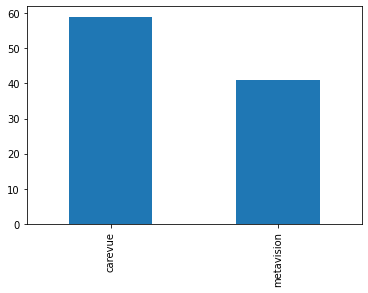

In [35]:
sample['dbsource'].value_counts().plot.bar()

In [36]:
train_data['dbsource'].value_counts()

carevue       72
metavision    52
Name: dbsource, dtype: int64

<AxesSubplot:>

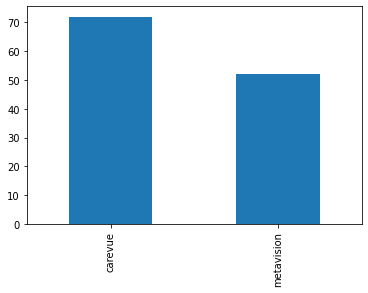

In [37]:
train_data['dbsource'].value_counts().plot.bar()